# [Going Deeper NLP 04] DTM, TF-IDF Vocabulary Size실험 

Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 패키지인 SentencePiece를 사용하는 프로젝트입니다. 

---

## 프로젝트 목표
---
- vocabulary size에 따른 모델 성능 비교
- reuters 뉴스 데이터를 이용해 뉴스 카테고리 다중분류를 한다. 

## 프로젝트 설명
---
1. reuters 뉴스 데이터를 불러온다. (이 때 단어의 수를 조절할 수 있다.) 
    - 전체 단어
    - 5000개 단어
    - 그 외로 실험해보기(3가지)
2. 머신러닝 모델 학습
    - 나이브 베이즈 분류기
    - CNB
    - 로지스틱 회귀
    - 서포트 벡터 머신(SVM)
    - 결정 트리
    - 랜덤 포레스트
    - 그래디언트 부스팅 트리
    - 보팅 
    
## 0. 모듈 Import

In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## 데이터 불러오기 및 분석, 전처리 

### (1) 모든 단어 사용 
- 실험을 위해 데이터셋의 모든 단어를 사용한다.
- 해당 데이터셋은 정수 시퀀스로 변환되어 제공된다. 

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [4]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


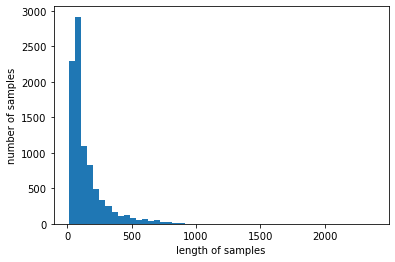

In [5]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [6]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

- 0, 1, 2번에 \<pad>, \<sos>, \<unk> 토큰이 매핑되어있다.    
- 이를 위해 index에 3을 더해주는 추가 작업이 필요함

In [7]:
index_to_word = {index + 3 : word for word, index in word_index.items()}

In [8]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

- 0번째 샘플로 확인

In [9]:
x_train[0]

[1,
 27595,
 28842,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

In [10]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


- 전체 데이터 변환(train, test)

In [11]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

In [12]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

## 2. 벡터화 하기
- Document Term Matrix, DTM을 활용한 TF-IDF행렬로 벡터화한다.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

- DTM 생성

In [14]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


- TF-IDF 생성

In [16]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


## 3. 머신러닝 모델 학습
- 나이브 베이즈 분류기
- Complement Naive Bayes Classifier, CNB
- 로지스틱 회귀
- 서포트 벡터 머신(SVM)
- 결정 트리
- 랜덤 포레스트
- 그래디언트 부스팅 트리
- 보팅 

In [17]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

- train데이터를 TF-IDF행렬로 변환한 것처럼 test데이터도 변환합니다.
- 정확도를 측정하기 위함 

In [38]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

In [42]:
def train_ml(tfidfv, y_train, tfidfv_test, y_test):
    # 나이브 베이즈 분류기 
    mod = MultinomialNB()
    mod.fit(tfidfv, y_train)
    
    mod_predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("나이브 베이즈 정확도:", accuracy_score(y_test, mod_predicted)) #예측값과 실제값 비교
    
    # CNB
    cb = ComplementNB()
    cb.fit(tfidfv, y_train)
    
    cb_predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("CNB 정확도:", accuracy_score(y_test, cb_predicted)) #예측값과 실제값 비교
    
    # 로지스틱 회귀 
    lr = LogisticRegression(C=10000, penalty='l2')
    lr.fit(tfidfv, y_train)

    lr_predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("로지스틱 회귀 정확도:", accuracy_score(y_test, lr_predicted)) #예측값과 실제값 비교
    
    # 선형 서포트 벡터 머신 
    lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
    lsvc.fit(tfidfv, y_train)
    
    lsvc_predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("SVM 정확도:", accuracy_score(y_test, lsvc_predicted)) #예측값과 실제값 비교
    
    # 결정 트리(Decision Tree) 
    tree = DecisionTreeClassifier(max_depth=10, random_state=0)
    tree.fit(tfidfv, y_train)
    
    tree_predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("결정 트리 정확도:", accuracy_score(y_test, tree_predicted)) #예측값과 실제값 비교
    
    # 랜덤 포레스트(Random Forest)
    forest = RandomForestClassifier(n_estimators=5, random_state=0)
    forest.fit(tfidfv, y_train)
    
    forest_predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("랜덤 포레스트 정확도:", accuracy_score(y_test, forest_predicted)) #예측값과 실제값 비교
    
    # 그래디언트 부스팅 트리(GradientBoostingClassifier)
    grbt = GradientBoostingClassifier(random_state=0, verbose=3) # verbose=3
    grbt.fit(tfidfv, y_train)

    grbt_predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("그래디언트 부스팅 트리 정확도:", accuracy_score(y_test, grbt_predicted)) #예측값과 실제값 비교
    
    # 보팅(Voting)
    voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
        ], voting='soft', n_jobs=-1)
    voting_classifier.fit(tfidfv, y_train)
    
    voting_classifier_predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("보팅 정확도:", accuracy_score(y_test, voting_classifier_predicted)) #예측값과 실제값 비교
    
    return mod, cb, lr, lsvc, tree, forest, grbt, voting_classifier

In [44]:
mod, cb, lr, lsvc, tree, forest, grbt, voting_classifier = train_ml(tfidfv, y_train, tfidfv_test, y_test)

나이브 베이즈 정확도: 0.5997328584149599
CNB 정확도: 0.7649154051647373


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도: 0.813446126447017


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도: 0.784060552092609
결정 트리 정확도: 0.6211041852181657
랜덤 포레스트 정확도: 0.6544968833481746
그래디언트 부스팅 트리 정확도: 0.7702582368655387
보팅 정확도: 0.8187889581478184


### (2) 단어 5000개 사용 

In [26]:
(x_train_5k, y_train_5k), (x_test_5k, y_test_5k) = reuters.load_data(num_words=5000, test_split=0.2)

In [27]:
decoded = []
for i in range(len(x_train_5k)):
    t = ' '.join([index_to_word[index] for index in x_train_5k[i]])
    decoded.append(t)

x_train_5k = decoded

In [28]:
decoded = []
for i in range(len(x_test_5k)):
    t = ' '.join([index_to_word[index] for index in x_test_5k[i]])
    decoded.append(t)

x_test_5k = decoded

- 행렬 변환

In [29]:
dtmvector = CountVectorizer()
x_train_dtm_5k = dtmvector.fit_transform(x_train_5k)
print(x_train_dtm_5k.shape)

(8982, 4867)


In [30]:
tfidf_transformer = TfidfTransformer()
tfidfv_5k = tfidf_transformer.fit_transform(x_train_dtm_5k)
print(tfidfv_5k.shape)

(8982, 4867)


In [31]:
x_test_dtm_5k = dtmvector.transform(x_test_5k) # 테스트 데이터를 DTM으로 변환
tfidfv_test_5k = tfidf_transformer.transform(x_test_dtm_5k) # DTM을 TF-IDF 행렬로 변환

In [51]:
import time
start = time.time() 

mod_5k, cb_5k, lr_5k, lsvc_5k, tree_5k, forest_5k, grbt_5k, voting_classifier_5k = train_ml(tfidfv_5k, y_train_5k, tfidfv_test_5k, y_test_5k)

print("time :", time.time() - start)

나이브 베이즈 정확도: 0.6731967943009796
CNB 정확도: 0.7707034728406055


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도: 0.8058771148708815


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도: 0.7666963490650045
결정 트리 정확도: 0.6179875333926982
랜덤 포레스트 정확도: 0.701246660730187
그래디언트 부스팅 트리 정확도: 0.767586821015138
보팅 정확도: 0.8161175422974176
time : 1338.3355541229248


### (3-1) 단어 1000개 사용

In [59]:
(x_train_1k, y_train_1k), (x_test_1k, y_test_1k) = reuters.load_data(num_words=1000, test_split=0.2)

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [60]:
decoded = []
for i in range(len(x_train_1k)):
    t = ' '.join([index_to_word[index] for index in x_train_1k[i]])
    decoded.append(t)

x_train_1k = decoded

In [61]:
decoded = []
for i in range(len(x_test_1k)):
    t = ' '.join([index_to_word[index] for index in x_test_1k[i]])
    decoded.append(t)

x_test_1k = decoded

- 행렬 변환

In [62]:
dtmvector = CountVectorizer()
x_train_dtm_1k = dtmvector.fit_transform(x_train_1k)
print(x_train_dtm_1k.shape)

(8982, 969)


In [63]:
tfidf_transformer = TfidfTransformer()
tfidfv_1k = tfidf_transformer.fit_transform(x_train_dtm_1k)
print(tfidfv_1k.shape)

(8982, 969)


In [64]:
x_test_dtm_1k = dtmvector.transform(x_test_1k) #테스트 데이터를 DTM으로 변환
tfidfv_test_1k = tfidf_transformer.transform(x_test_dtm_1k) #DTM을 TF-IDF 행렬로 변환

In [66]:
import time
import datetime

start = time.time() 

mod_1k, cb_1k, lr_1k, lsvc_1k, tree_1k, forest_1k, grbt_1k, voting_classifier_1k = train_ml(tfidfv_1k, y_train_1k, tfidfv_test_1k, y_test_1k)


sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('run time :', times)

나이브 베이즈 정확도: 0.6856634016028496
CNB 정확도: 0.7346393588601959


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도: 0.780053428317008


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도: 0.7172751558325913
결정 트리 정확도: 0.6179875333926982
랜덤 포레스트 정확도: 0.707479964381122
그래디언트 부스팅 트리 정확도: 0.7457702582368655
보팅 정확도: 0.7845057880676759
run time : 0:18:14


### (3-2) 단어 10000개 사용

In [67]:
(x_train_10k, y_train_10k), (x_test_10k, y_test_10k) = reuters.load_data(num_words=10000, test_split=0.2)

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [68]:
decoded = []
for i in range(len(x_train_10k)):
    t = ' '.join([index_to_word[index] for index in x_train_10k[i]])
    decoded.append(t)

x_train_10k = decoded

In [69]:
decoded = []
for i in range(len(x_test_10k)):
    t = ' '.join([index_to_word[index] for index in x_test_10k[i]])
    decoded.append(t)

x_test_10k = decoded

- 행렬 변환

In [70]:
dtmvector = CountVectorizer()
x_train_dtm_10k = dtmvector.fit_transform(x_train_10k)
print(x_train_dtm_10k.shape)

(8982, 9670)


In [71]:
tfidf_transformer = TfidfTransformer()
tfidfv_10k = tfidf_transformer.fit_transform(x_train_dtm_10k)
print(tfidfv_10k.shape)

(8982, 9670)


In [72]:
x_test_dtm_10k = dtmvector.transform(x_test_10k) #테스트 데이터를 DTM으로 변환
tfidfv_test_10k = tfidf_transformer.transform(x_test_dtm_10k) #DTM을 TF-IDF 행렬로 변환

In [73]:
start = time.time() 

mod_10k, cb_10k, lr_10k, lsvc_10k, tree_10k, forest_10k, grbt_10k, voting_classifier_10k = train_ml(tfidfv_10k, y_train_10k, tfidfv_test_10k, y_test_10k)

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('run time :', times)

나이브 베이즈 정확도: 0.6567230632235085
CNB 정확도: 0.7707034728406055


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도: 0.8076580587711487


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도: 0.7813891362422084
결정 트리 정확도: 0.6202137132680321
랜덤 포레스트 정확도: 0.674087266251113
그래디언트 부스팅 트리 정확도: 0.7666963490650045
보팅 정확도: 0.8116651825467498
run time : 0:22:25


### (3-3) 단어 20000개 사용

In [32]:
(x_train_20k, y_train_20k), (x_test_20k, y_test_20k) = reuters.load_data(num_words=20000, test_split=0.2)

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/reuters.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [33]:
decoded = []
for i in range(len(x_train_20k)):
    t = ' '.join([index_to_word[index] for index in x_train_20k[i]])
    decoded.append(t)

x_train_20k = decoded

In [34]:
decoded = []
for i in range(len(x_test_20k)):
    t = ' '.join([index_to_word[index] for index in x_test_20k[i]])
    decoded.append(t)

x_test_20k = decoded

- 행렬 변환

In [35]:
dtmvector = CountVectorizer()
x_train_dtm_20k = dtmvector.fit_transform(x_train_20k)
print(x_train_dtm_20k.shape)

(8982, 18479)


In [36]:
tfidf_transformer = TfidfTransformer()
tfidfv_20k = tfidf_transformer.fit_transform(x_train_dtm_20k)
print(tfidfv_20k.shape)

(8982, 18479)


In [37]:
x_test_dtm_20k = dtmvector.transform(x_test_20k) #테스트 데이터를 DTM으로 변환
tfidfv_test_20k = tfidf_transformer.transform(x_test_dtm_20k) #DTM을 TF-IDF 행렬로 변환

In [81]:
start = time.time() 

mod_20k, cb_20k, lr_20k, lsvc_20k, tree_20k, forest_20k, grbt_20k, voting_classifier_20k = train_ml(tfidfv_20k, y_train_20k, tfidfv_test_20k, y_test_20k)

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('run time :', times)

나이브 베이즈 정확도: 0.6193232413178985
CNB 정확도: 0.7671415850400712


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도: 0.8098842386464826


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도: 0.7778272484416741
결정 트리 정확도: 0.6211041852181657
랜덤 포레스트 정확도: 0.6714158504007124
그래디언트 부스팅 트리 정확도: 0.769813000890472
보팅 정확도: 0.8178984861976848
run time : 0:23:15


### 성능 평가
- 각 vocab size별 모델의 정확도를 이용해 성능을 평가한다.

### 전체 단어 
- 나이브 베이즈 정확도: 0.5997328584149599     
- CNB 정확도: 0.7649154051647373                 
- 로지스틱 회귀 정확도: 0.813446126447017
- SVM 정확도: 0.784060552092609
- 결정 트리 정확도: 0.6211041852181657
- 랜덤 포레스트 정확도: 0.6544968833481746
- 그래디언트 부스팅 트리 정확도: 0.7702582368655387
- 보팅 정확도: 0.8187889581478184

### 5000개
- 나이브 베이즈 정확도: 0.6731967943009796
- CNB 정확도: 0.7707034728406055
- 로지스틱 회귀 정확도: 0.8058771148708815
- SVM 정확도: 0.7666963490650045
- 결정 트리 정확도: 0.6179875333926982
- 랜덤 포레스트 정확도: 0.701246660730187
- 그래디언트 부스팅 트리 정확도: 0.767586821015138
- 보팅 정확도: 0.8161175422974176

### 1000개
- 나이브 베이즈 정확도: 0.6856634016028496
- CNB 정확도: 0.7346393588601959
- 로지스틱 회귀 정확도: 0.780053428317008
- SVM 정확도: 0.7172751558325913
- 결정 트리 정확도: 0.6179875333926982
- 랜덤 포레스트 정확도: 0.707479964381122
- 그래디언트 부스팅 트리 정확도: 0.7457702582368655
- 보팅 정확도: 0.7845057880676759

### 10000개
- 나이브 베이즈 정확도: 0.6567230632235085
- CNB 정확도: 0.7707034728406055
- 로지스틱 회귀 정확도: 0.8076580587711487
- SVM 정확도: 0.7813891362422084
- 결정 트리 정확도: 0.6202137132680321
- 랜덤 포레스트 정확도: 0.674087266251113
- 그래디언트 부스팅 트리 정확도: 0.7666963490650045
- 보팅 정확도: 0.8116651825467498

### 20000개
- 나이브 베이즈 정확도: 0.6193232413178985
- CNB 정확도: 0.7671415850400712
- 로지스틱 회귀 정확도: 0.8098842386464826
- SVM 정확도: 0.7778272484416741
- 결정 트리 정확도: 0.6211041852181657
- 랜덤 포레스트 정확도: 0.6714158504007124
- 그래디언트 부스팅 트리 정확도: 0.769813000890472
- 보팅 정확도: 0.8178984861976848

In [53]:
bayse = [0.5997328584149599, 0.6731967943009796, 0.6856634016028496, 0.6567230632235085, 0.6193232413178985]
cnb = [0.7649154051647373, 0.7707034728406055, 0.7346393588601959, 0.7707034728406055, 0.7671415850400712]
logistic = [0.813446126447017, 0.8058771148708815, 0.7346393588601959, 0.7707034728406055, 0.7671415850400712]
svm = [0.784060552092609, 0.7666963490650045, 0.7172751558325913, 0.7813891362422084, 0.7778272484416741]
tree = [0.6211041852181657, 0.6179875333926982, 0.6179875333926982, 0.6202137132680321, 0.6211041852181657]
rf = [0.6544968833481746, 0.701246660730187, 0.707479964381122, 0.674087266251113, 0.6714158504007124]
gbs = [0.7702582368655387, 0.767586821015138, 0.7457702582368655, 0.7666963490650045, 0.769813000890472]
voting = [0.8187889581478184, 0.8161175422974176, 0.7845057880676759, 0.8116651825467498, 0.8178984861976848]

vocab_size_list = ['whole', '5k', '1k', '10k', '20k']
model_list = [bayse, cnb, logistic, svm, tree, rf, gbs, voting]

In [86]:
acc_dict = {}
for idx, vs in enumerate(vocab_size_list):
    acc_list = []
    for model in model_list:
        acc_list.append(model[idx])
    acc_dict[vs] = sum(acc_list)/len(model_list)

In [87]:
acc_dict

{'whole': 0.7283504007123776,
 '5k': 0.7399265360641141,
 '1k': 0.7159951024042743,
 '10k': 0.7315227070347284,
 '20k': 0.7264581478183436}

### 각 모델의 정확도 확인 결과, 5000개의 단어 개수가 가장 정확도가 높았음을 알 수 있었다. 

## 4. 딥러닝 모델 학습

In [22]:
from tensorflow import keras

vocab_size = 20000
word_vector_dim = 32  

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim))
model_LSTM.add(keras.layers.LSTM(32))
# model_LSTM.add(keras.layers.Dense(128, activation='relu'))  
model_LSTM.add(keras.layers.Dense(num_classes, activation='softmax'))  

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 46)                1518      
Total params: 649,838
Trainable params: 649,838
Non-trainable params: 0
_________________________________________________________________


In [47]:
tfidfv_20k.shape, y_train_20k.shape

((8982, 18479), (8982,))

### 학습 데이터 실험
- sparse한 행렬을 dense하게 만들기 위해 두가지 변환으로 실험
1. toarray() : array로 변환(에러메세지에서 추천하는 방법)
2. todense() : Return a dense matrix representation of this matrix.

In [39]:
tfidfv_20k_arr = tfidfv_20k.toarray()
tfidfv_20k_dense = tfidfv_20k.todense()

In [40]:
tfidfv_test_20k_arr = tfidfv_test_20k.toarray()
tfidfv_test_20k_dense = tfidfv_test_20k.todense()

In [27]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

model_LSTM.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
            
epochs=20
batch_size=64


history_LSTM = model_LSTM.fit(tfidfv_20k_arr,
                                y_train_20k,
                                epochs=epochs,
                                batch_size=batch_size,
                                callbacks=[es],
                                validation_split=0.2,
                                verbose=1)

Train on 7185 samples, validate on 1797 samples
Epoch 1/20
7185/7185 [==============================] - 82s 11ms/sample - loss: 2.7577 - accuracy: 0.3441 - val_loss: 2.4127 - val_accuracy: 0.3450
Epoch 2/20
7185/7185 [==============================] - 79s 11ms/sample - loss: 2.4090 - accuracy: 0.3534 - val_loss: 2.4080 - val_accuracy: 0.3450
Epoch 3/20
7185/7185 [==============================] - 80s 11ms/sample - loss: 2.4071 - accuracy: 0.3534 - val_loss: 2.4078 - val_accuracy: 0.3450
Epoch 4/20
7185/7185 [==============================] - 79s 11ms/sample - loss: 2.4065 - accuracy: 0.3534 - val_loss: 2.4085 - val_accuracy: 0.3450
Epoch 5/20
7185/7185 [==============================] - 78s 11ms/sample - loss: 2.4069 - accuracy: 0.3534 - val_loss: 2.4062 - val_accuracy: 0.3450
Epoch 6/20
7185/7185 [==============================] - 78s 11ms/sample - loss: 2.4062 - accuracy: 0.3534 - val_loss: 2.4057 - val_accuracy: 0.3450
Epoch 7/20
7185/7185 [==============================] - 79s 11ms

In [30]:
results = model_LSTM.evaluate(tfidfv_test_20k_arr,  y_test_20k, verbose=2)
print(results)

2246/2246 - 19s - loss: 2.4174 - accuracy: 0.3620
[2.4173861999970296, 0.36197686]


In [30]:
from tensorflow import keras

vocab_size = 20000
word_vector_dim = 32  

model_LSTM_dense = keras.Sequential()
model_LSTM_dense.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim))
model_LSTM_dense.add(keras.layers.LSTM(32))
# model_LSTM_dense.add(keras.layers.Dense(128, activation='relu'))  
model_LSTM_dense.add(keras.layers.Dense(num_classes, activation='softmax'))  

model_LSTM_dense.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          640000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 46)                1518      
Total params: 649,838
Trainable params: 649,838
Non-trainable params: 0
_________________________________________________________________


In [31]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

model_LSTM_dense.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
            
epochs=20
batch_size=64

history_LSTM_dense = model_LSTM_dense.fit(tfidfv_20k_desnse,
                                y_train_20k,
                                epochs=epochs,
                                batch_size=batch_size,
                                callbacks=[es],
                                validation_split=0.2,
                                verbose=1)

Train on 7185 samples, validate on 1797 samples
Epoch 1/20
7185/7185 [==============================] - 78s 11ms/sample - loss: 2.7400 - accuracy: 0.3482 - val_loss: 2.4057 - val_accuracy: 0.3450
Epoch 2/20
7185/7185 [==============================] - 77s 11ms/sample - loss: 2.4085 - accuracy: 0.3534 - val_loss: 2.4080 - val_accuracy: 0.3450
Epoch 3/20
7185/7185 [==============================] - 77s 11ms/sample - loss: 2.4079 - accuracy: 0.3534 - val_loss: 2.4091 - val_accuracy: 0.3450
Epoch 4/20
7185/7185 [==============================] - 76s 11ms/sample - loss: 2.4060 - accuracy: 0.3534 - val_loss: 2.4055 - val_accuracy: 0.3450
Epoch 5/20
7185/7185 [==============================] - 76s 11ms/sample - loss: 2.4064 - accuracy: 0.3534 - val_loss: 2.4080 - val_accuracy: 0.3450
Epoch 6/20
7185/7185 [==============================] - 76s 11ms/sample - loss: 2.4070 - accuracy: 0.3534 - val_loss: 2.4081 - val_accuracy: 0.3450
Epoch 7/20
7185/7185 [==============================] - 76s 11ms

In [33]:
results_dense = model_LSTM_dense.evaluate(tfidfv_test_20k_dense,  y_test_20k, verbose=2)
print(results_dense)

2246/2246 - 16s - loss: 2.4157 - accuracy: 0.3620
[2.415727226625886, 0.36197686]


- toarray() : \[2.4173861999970296, 0.36197686\]
- todense() : \[2.415727226625886, 0.36197686\]

**toarray(), todense()로 학습한 결과 큰 차이가 나지 않았다.**

- 인풋에 대해 sparse함을 확인할 수 있는 scipy의 **issparse**를 이용해 확인한다.

In [39]:
sparse.issparse(tfidfv_test_20k)

True

In [37]:
from scipy import sparse 

sparse.issparse(tfidfv_test_20k_dense)

False

In [38]:
sparse.issparse(tfidfv_test_20k_arr)

False

- toarray(), todense() 모두 sparse했던 행렬을 dense하게 변환시킨 것을 확인했다. 
- TF-IDF행렬로 vectorizing한 input을 사용하기 때문에 행렬형태인 todense()의 결과를 모델에 사용하겠다.

### 성능 향상
- 모델의 레이어를 추가하며 accuracy를 향상시킨다.

In [41]:
from tensorflow import keras

def rnn(num_layer=8):

    model_dense = keras.Sequential()
    model_dense.add(keras.layers.Dense(num_layer*4, activation='relu', input_shape=(tfidfv_20k_dense.shape[1],)))  
    model_dense.add(keras.layers.Dense(num_layer*4, activation='relu')) 
    model_dense.add(keras.layers.Dense(num_layer*8, activation='relu')) 
    model_dense.add(keras.layers.Dense(num_layer*16, activation='relu'))  
    model_dense.add(keras.layers.Dense(num_classes, activation='softmax'))  

    model_dense.summary()
    
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

    model_dense.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    epochs=20
    batch_size=128

    history_dense = model_dense.fit(tfidfv_20k_dense,
                                    y_train_20k,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    callbacks=[es],
                                    validation_split=0.2,
                                    verbose=1)
    
    results = model_dense.evaluate(tfidfv_test_20k_dense,  y_test_20k, verbose=2)
    print(results)
    
    return history_dense, model_dense

In [42]:
history_dense, model_dense = rnn()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                591360    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 46)                5934      
Total params: 608,782
Trainable params: 608,782
Non-trainable params: 0
_________________________________________________________________
Train on 7185 samples, validate on 1797 samples
Epoch 1/20
7185/7185 [==============================] - 1s 157us/sam

In [27]:
def visualize_train(train_history):
    # summarize history for accuracy
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

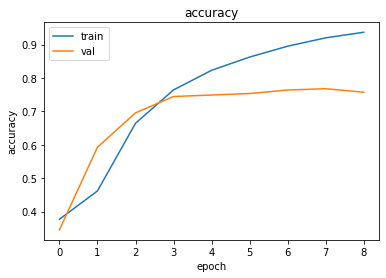

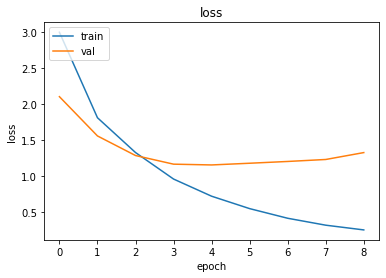

In [28]:
visualize_train(history_dense)

In [49]:
model_dense.predict(tfidfv_test_20k_dense)

array([[2.3596578e-09, 1.1202242e-02, 2.6613529e-08, ..., 2.6299460e-08,
        5.1851712e-10, 6.4061179e-10],
       [9.9257195e-05, 2.4428587e-05, 1.8817149e-05, ..., 2.7162274e-11,
        3.8502634e-08, 1.3857623e-09],
       [1.5992306e-05, 6.6110200e-01, 6.8357554e-03, ..., 1.9274550e-05,
        5.9376680e-06, 8.0461041e-07],
       ...,
       [4.8251149e-13, 1.4291499e-05, 1.8133817e-12, ..., 3.7168546e-11,
        3.0184316e-13, 9.2020673e-13],
       [4.0048771e-04, 9.0070330e-02, 1.0920715e-03, ..., 2.9568464e-04,
        2.4221664e-04, 1.6702710e-04],
       [2.5708746e-04, 2.4997425e-01, 1.0343136e-01, ..., 6.5832995e-05,
        6.7426740e-06, 1.3649124e-06]], dtype=float32)

In [46]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test_20k, model_dense.predict(tfidfv_test_20k_dense).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.37      0.58      0.45        12
           1       0.66      0.72      0.69       105
           2       0.36      0.25      0.29        20
           3       0.86      0.95      0.90       813
           4       0.86      0.81      0.84       474
           5       0.25      0.20      0.22         5
           6       0.55      0.43      0.48        14
           7       0.00      0.00      0.00         3
           8       0.58      0.66      0.62        38
           9       0.71      0.68      0.69        25
          10       0.81      0.57      0.67        30
          11       0.59      0.69      0.63        83
          12       0.33      0.23      0.27        13
          13       0.37      0.46      0.41        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.70      0.56      0.62        99
          17       0.20    

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test).argmax(axis=1)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(15,15))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')

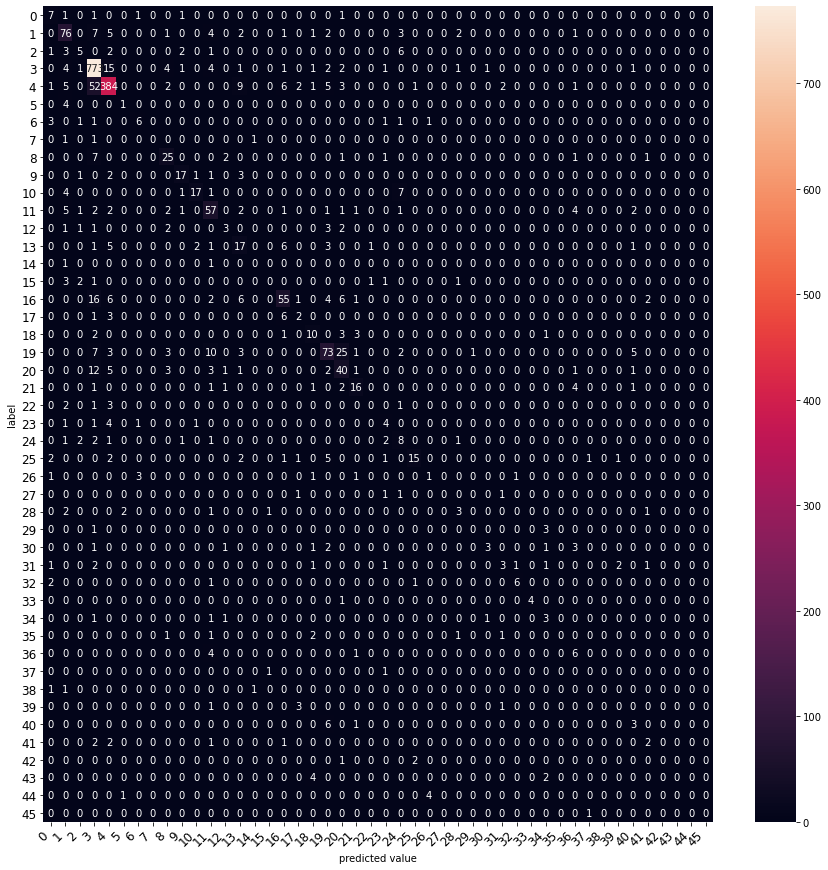

In [52]:
graph_confusion_matrix(model_dense, tfidfv_test_20k_dense, y_test_20k)

# 루브릭 평가
---
1. **분류 모델의 accuracy가 기준 이상 높게 나왔는가?**   

    - 5가지의 경우를 테스트하고 모델 별 accuracy를 확인했다.  


2. **분류 모델의 F1 score가 기준 이상 높게 나왔는가?**

    - f1 score를 출력해 높게 나온 것을 확인할 수 있었다. 
    
     
3. **생성모델의 metric(BLEU 등) 기준 이상 높은 성능이 확인되었는가?** 
 
     - confusion matrix, f1 score, 딥러닝 모델의 경우 test dataset의 accuracy를 확인했고, 기준 이상의 높은 성능을 확인했다. 


    
# 회고
---

## 어려웠던 부분 
- 머신러닝의 경우 학습시간이 오래걸렸고,  rnn으로 자주 사용되는 lstm으로 학습했을 때는 정확도가 나오지 않아서 어려웠다. 

## 알아낸 점 혹은 모호한 부분 
- dense layer로만 분류하는 것이 더 성능이 좋았다. 
- sparse한 행렬의 경우 학습이 이루어지지 않고, 이를 toarray(), todense()로 해결할 수 있었다.
- sparse함을 확인하는 함수, issparse()를 알게 되었다. 

## 평가기준을 위해 시도한 부분 
- 단어 크기 별 각 모델의 정확도를 계산해서 파라미터를 설정할 수 있었다. 

## 느낀 점 
- 이번에 과정을 함수로 만들어 시도하였는데 확실히 코드가 깔끔해지고 여러 실험을 간편하게 할 수 있음을 알게 되었다. 